In [5]:
from hdimvis.data_fetchers.DataFetcher import DataFetcher
from hdimvis.algorithms.stochastic_ntet_algo.SNeD import SNeD
from hdimvis.create_low_d_layout.LayoutCreation import LayoutCreation
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from experiments.utils.get_avg_classwise_f1 import get_avg_classwise_f1
from sklearn.cluster import KMeans
from experiments.utils.smooth_running_mean import smooth_running_mean
import numpy as np
from pathlib import Path
from definitions import PROJECT_ROOT
import pickle
from scipy import stats
import matplotlib.pyplot as plt

In [6]:
output_dir= (Path(PROJECT_ROOT).joinpath(
    Path(f"experiments/Nesterovs_momentum/out/"))).resolve().absolute()

path_to_pickle = (Path(output_dir).joinpath(Path(f"layouts.pickle"))).resolve()

with open(path_to_pickle, 'rb') as file:
    layouts = pickle.load(file)
dataset_names = ['rna N3k', 'coli20', 'globe', 'fashion mnist', 'mnist']

In [7]:
results = {dataset: np.zeros((20,2)) for dataset in dataset_names}

layouts_nesterov = layouts['nesterov']
layouts_no_nesterov = layouts['no nesterov']

for dataset_name in dataset_names:
    for i,layout in enumerate(layouts['nesterov'][dataset_name]):
        results[dataset_name][i,0] = layout.iteration_number
    for i,layout in enumerate(layouts['no nesterov'][dataset_name]):
        results[dataset_name][i,1] = layout.iteration_number


In [8]:
test_results = { dataset: [] for dataset in dataset_names}

for dataset_name, inter_nums in results.items():
    tstat, pvalue = stats.ttest_ind(inter_nums[:,0], inter_nums[:,1], equal_var=False, alternative='greater')
    test_results[dataset_name].append(np.format_float_scientific(pvalue, precision=2,min_digits=2))
    test_results[dataset_name].append(np.mean(inter_nums[:,0]))
    test_results[dataset_name].append(np.mean(inter_nums[:,1]))
    test_results[dataset_name].append(np.around(np.std(inter_nums[:,0]), decimals=1))
    test_results[dataset_name].append(np.around(np.std(inter_nums[:,1]), decimals=1))


print(test_results)

{'rna N3k': ['5.87e-05', 422.95, 363.9, 50.7, 28.5], 'coli20': ['2.72e-27', 206.6, 126.9, 9.1, 8.2], 'globe': ['5.63e-12', 138.35, 109.75, 8.9, 1.4], 'fashion mnist': ['2.38e-25', 356.65, 263.2, 11.7, 11.6], 'mnist': ['2.62e-29', 450.85, 308.2, 14.1, 13.4]}


In [23]:
ans_values = { dataset: {'nesterov': [], 'no nesterov': []} for dataset in dataset_names}
iterations_range = [300, 100, 90, 210, 280]
# extract the iter numbers and smoothed running means
for j, dataset_name in enumerate(dataset_names):
    arr_n = np.zeros((20,iterations_range[j],3))
    for i,layout in enumerate(layouts['nesterov'][dataset_name]):
        smoothed_stress_20 = smooth_running_mean(np.array(layout.collected_metrics["Average n-tet stress"][1][:iterations_range[j]]), 20)
        smoothed_stress_40 = smooth_running_mean(np.array(layout.collected_metrics["Average n-tet stress"][1][:iterations_range[j]]), 40)
        arr_n[i,:,0] = np.array(layout.collected_metrics["Average n-tet stress"][1][:iterations_range[j]])
        arr_n[i,:,1] = smoothed_stress_20
        arr_n[i,:,2] = smoothed_stress_40

    ans_values[dataset_name]['nesterov'].append(arr_n)

    arr_nn = np.zeros((20,iterations_range[j], 3))
    for i,layout in enumerate(layouts['no nesterov'][dataset_name]):
        smoothed_stress_20 = smooth_running_mean(np.array(layout.collected_metrics["Average n-tet stress"][1][:iterations_range[j]]), 20)
        smoothed_stress_40 = smooth_running_mean(np.array(layout.collected_metrics["Average n-tet stress"][1][:iterations_range[j]]), 40)
        arr_nn[i,:,0] = np.array(layout.collected_metrics["Average n-tet stress"][1][:iterations_range[j]])
        arr_nn[i,:,1] = smoothed_stress_20
        arr_nn[i,:,2] = smoothed_stress_40


    ans_values[dataset_name]['no nesterov'].append(arr_nn)

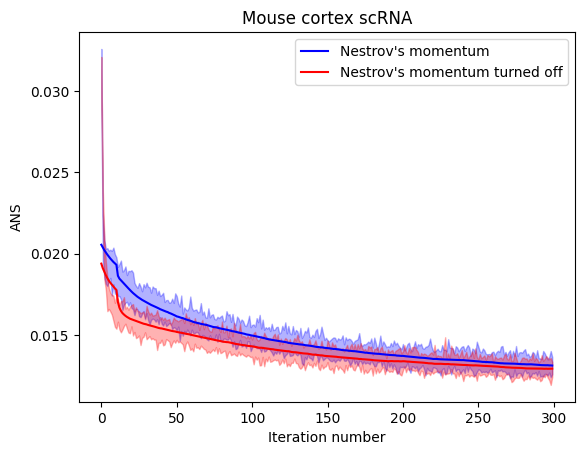

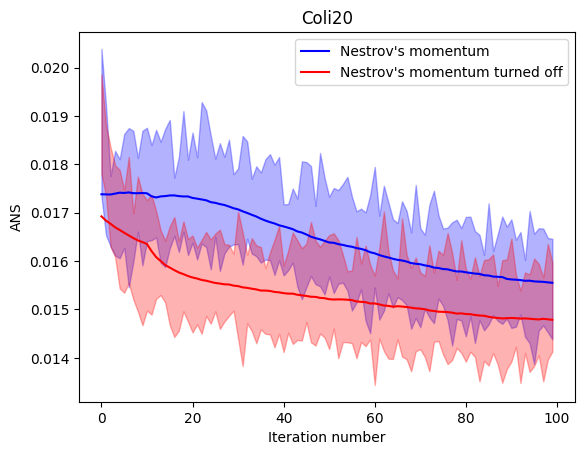

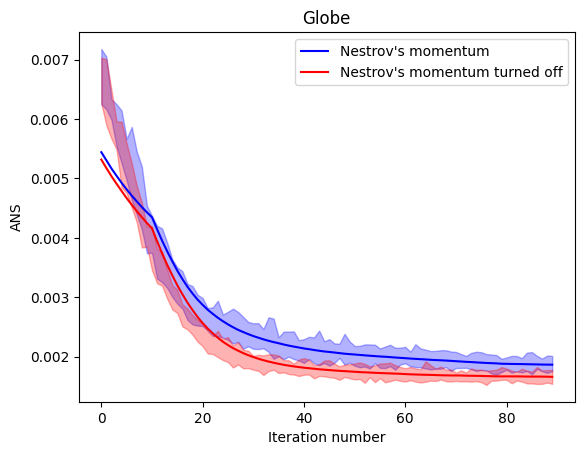

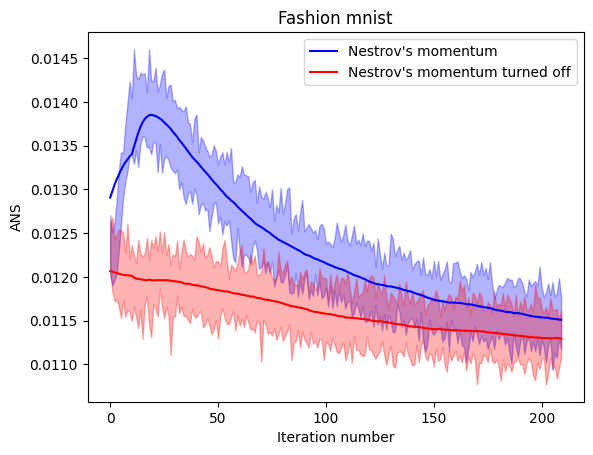

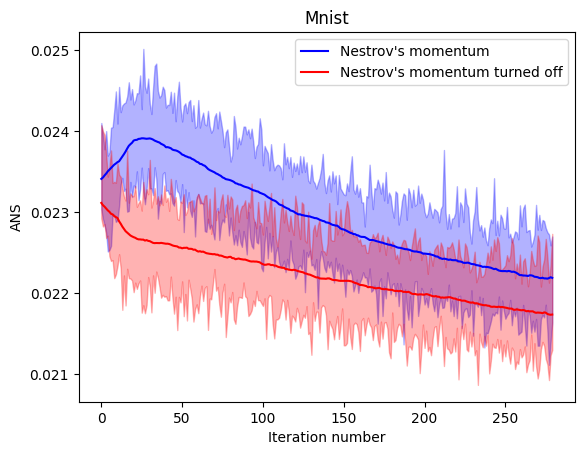

In [26]:

for i, dataset in enumerate(ans_values.values()):
    fig, ax = plt.subplots()
    x = np.arange(iterations_range[i])


    for col, type, label in [('b', 'nesterov', "Nestrov's momentum"), ('r', 'no nesterov', "Nestrov's momentum turned off")]:

        yu = np.max(dataset[type][0][:,:,0], axis=0)
        yd = np.min(dataset[type][0][:,:,0], axis=0)
        mean = np.mean(dataset[type][0][:,:,1], axis=0)
        ax.plot(x, mean, color=col, label=label)
        ax.fill_between(x, yu, yd, color=col, alpha = 0.3 )

    plt.ylabel("ANS")
    plt.xlabel("Iteration number")
    if i == 0:
        plt.title("Mouse cortex scRNA")
    else:
        plt.title(f"{dataset_names[i].capitalize()}")
    plt.legend()
    plt.show()

16
16


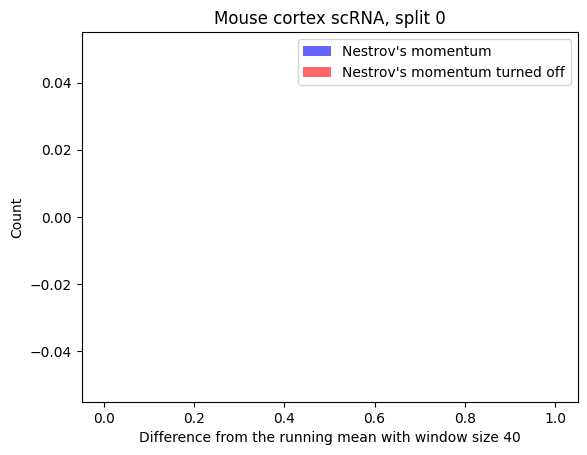

16
16


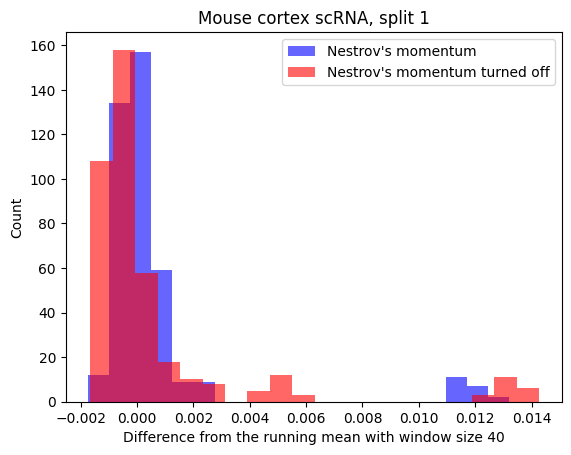

16
16


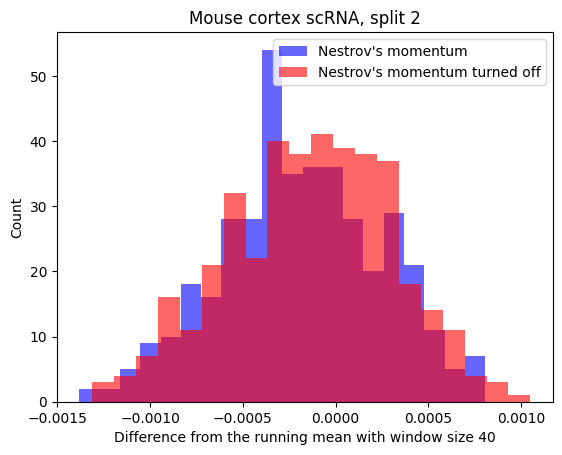

16
16


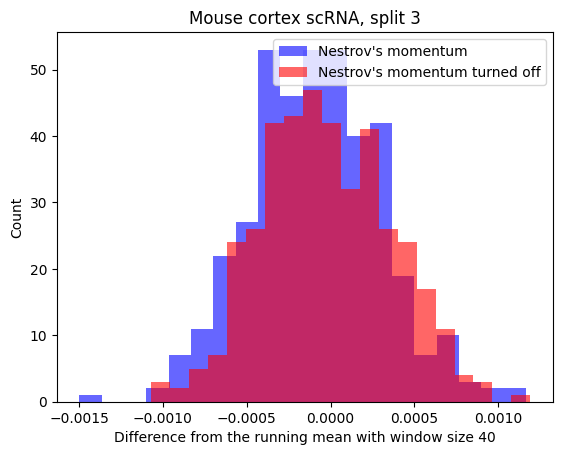

16
16


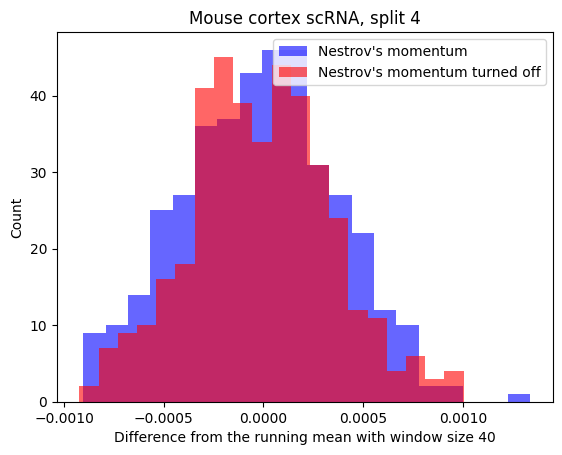

16
16


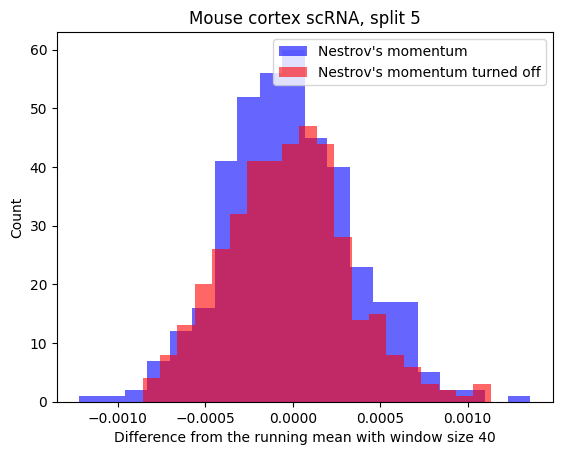

16
16


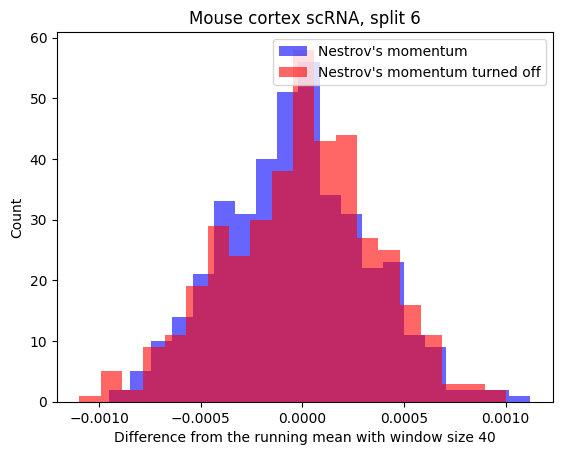

16
16


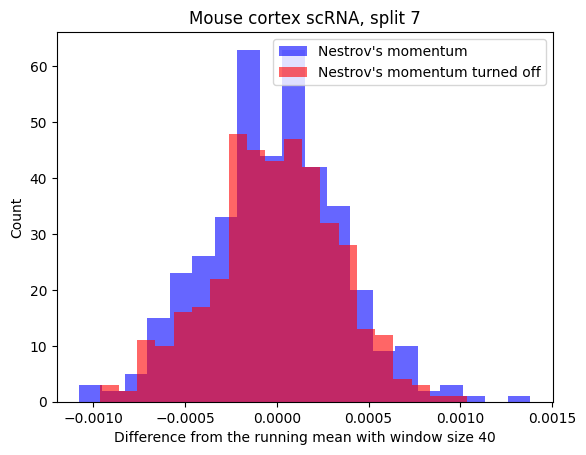

16
16


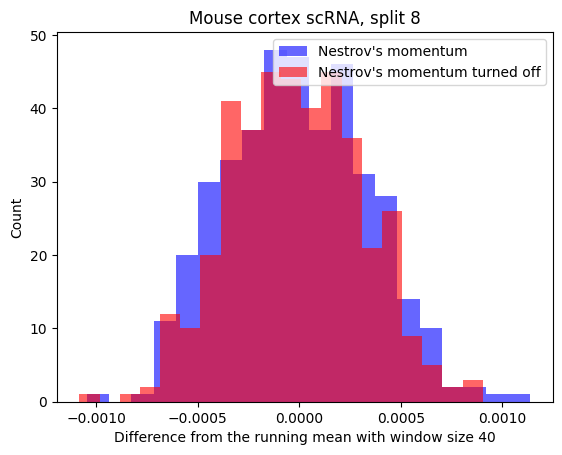

16
16


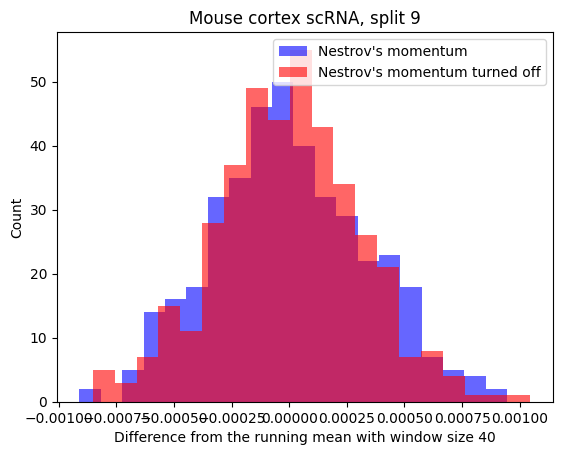

16
16


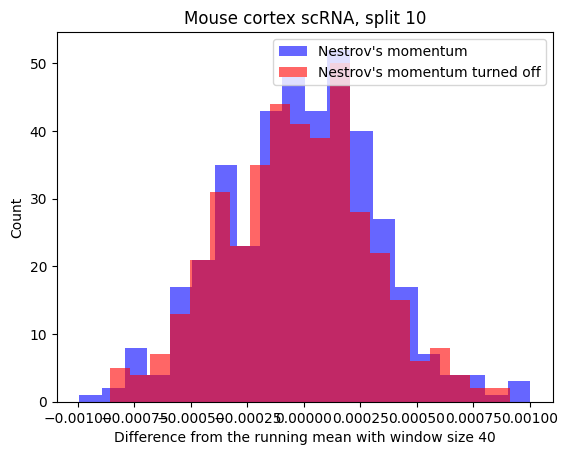

16
16


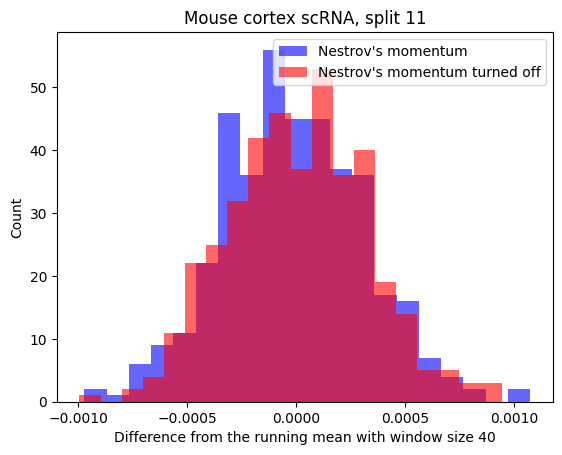

16
16


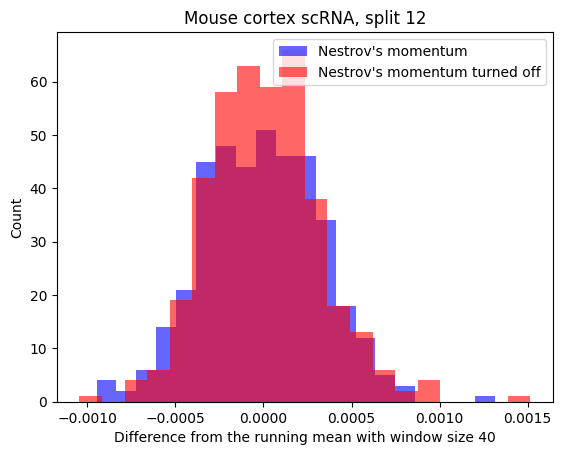

16
16


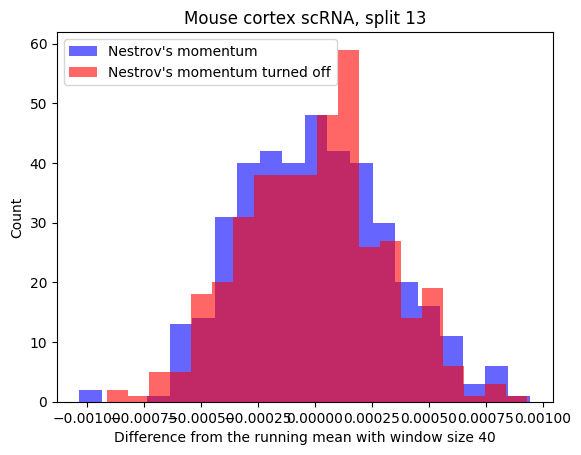

16
16


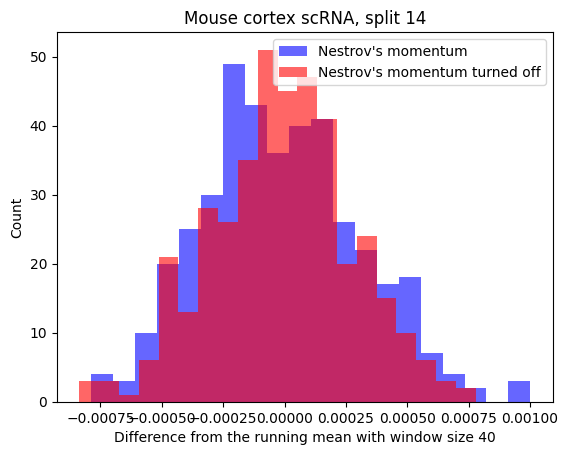

6
6


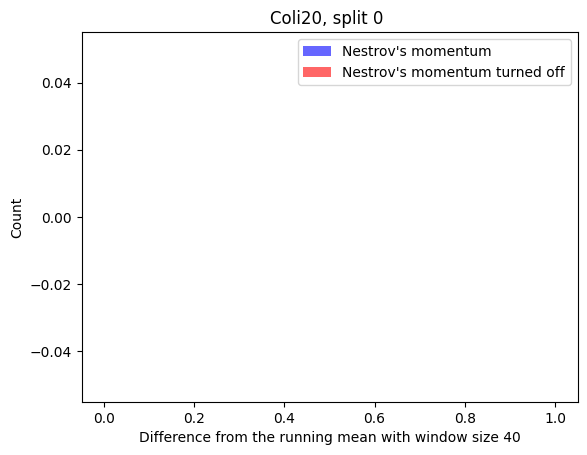

6
6


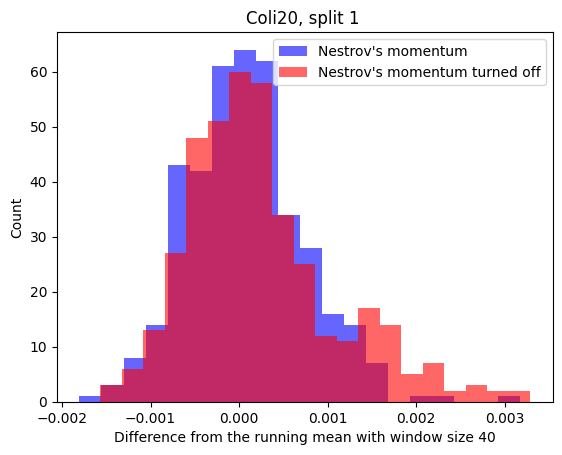

6
6


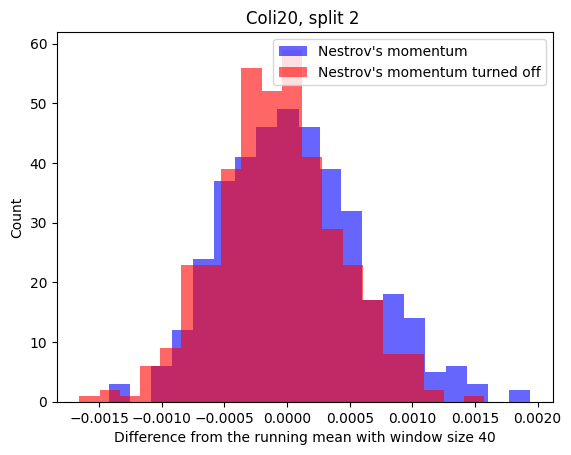

6
6


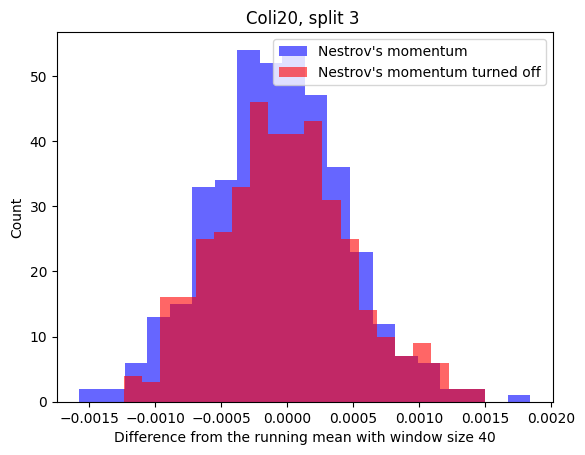

6
6


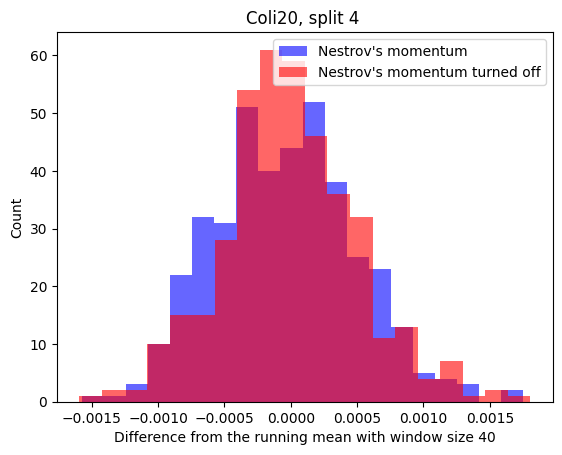

6
6


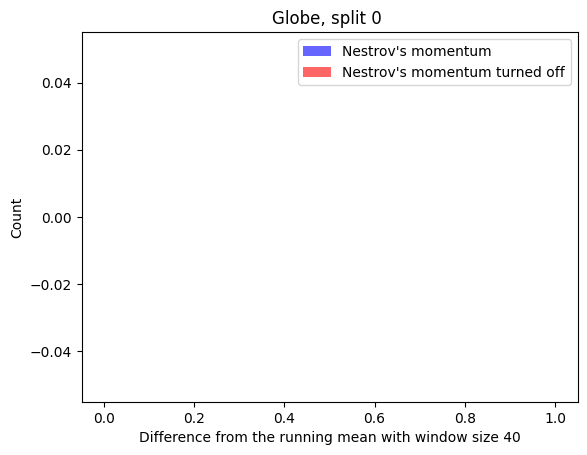

6
6


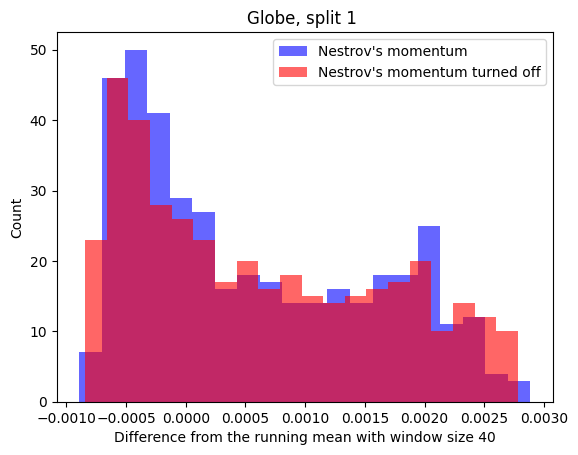

6
6


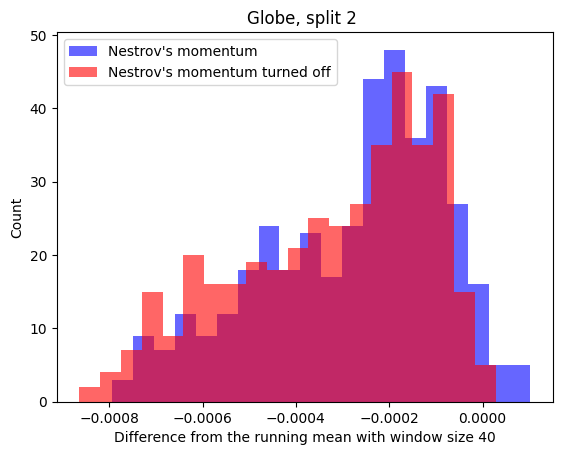

6
6


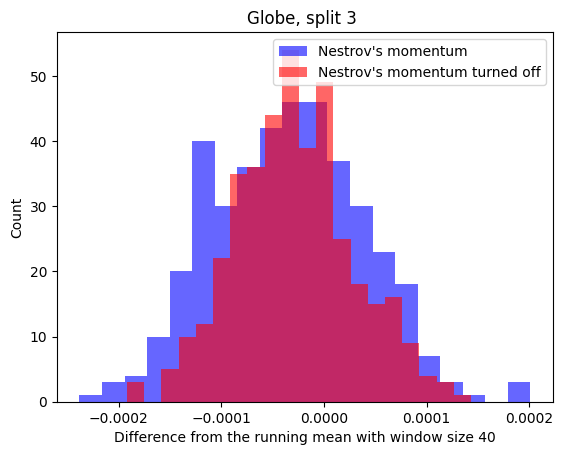

6
6


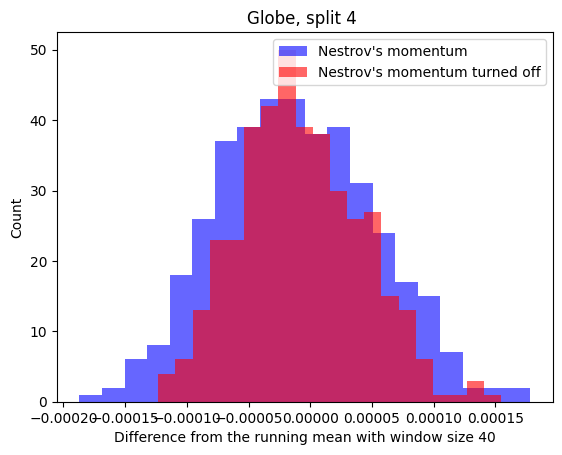

12
12


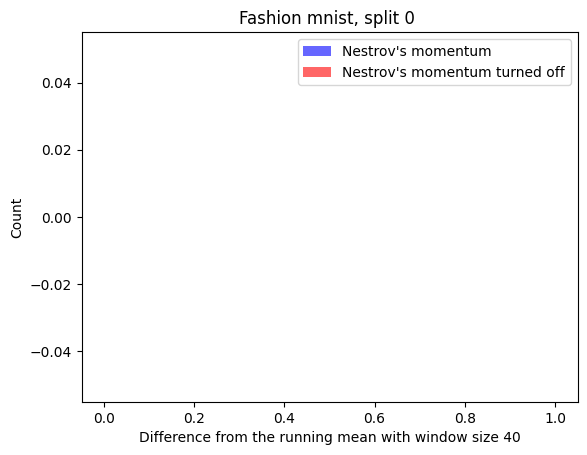

12
12


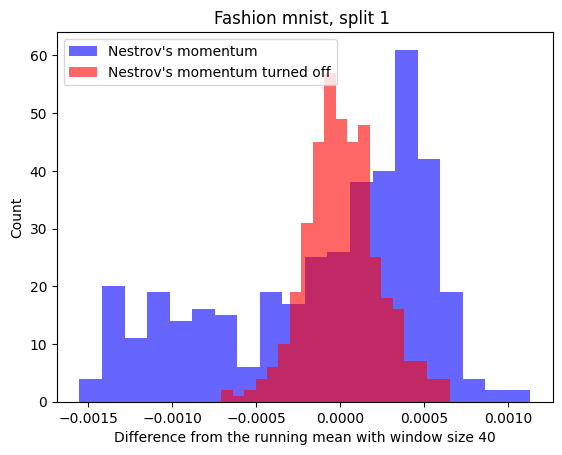

12
12


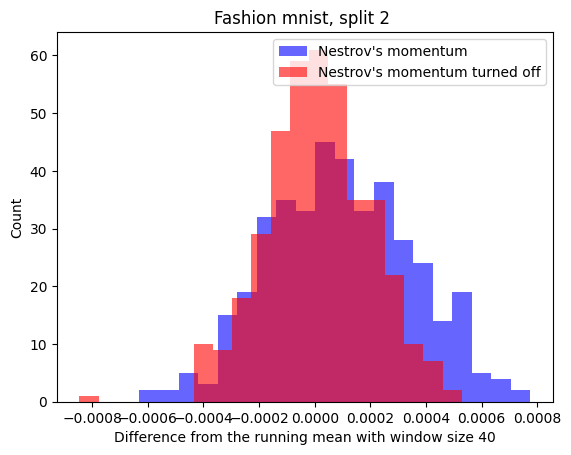

12
12


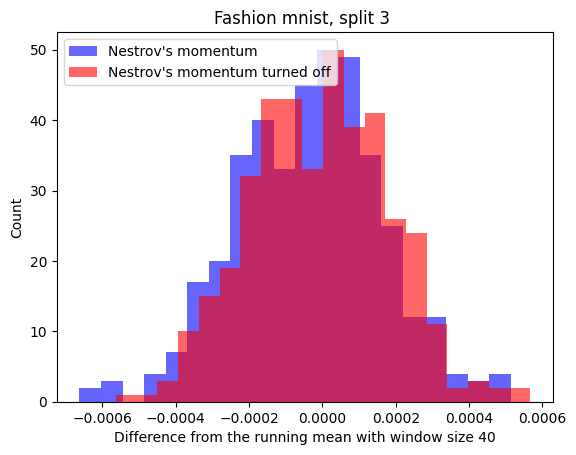

12
12


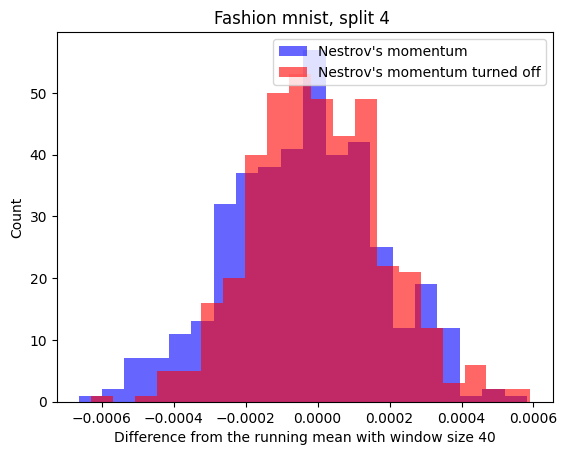

12
12


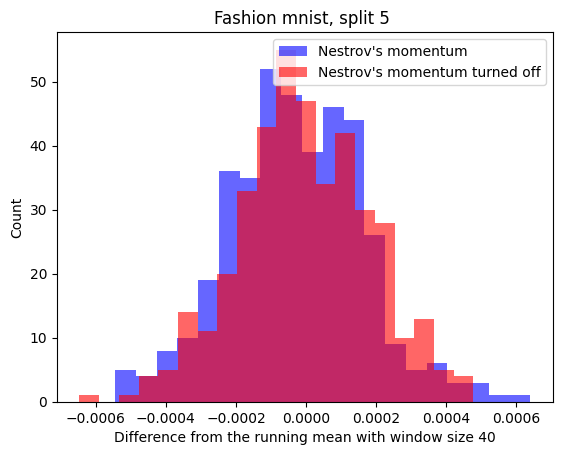

12
12


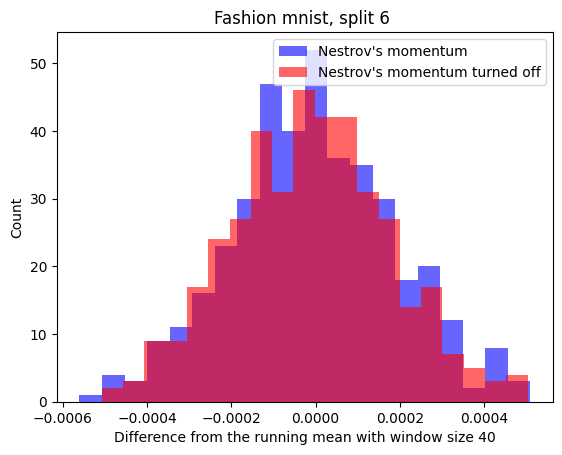

12
12


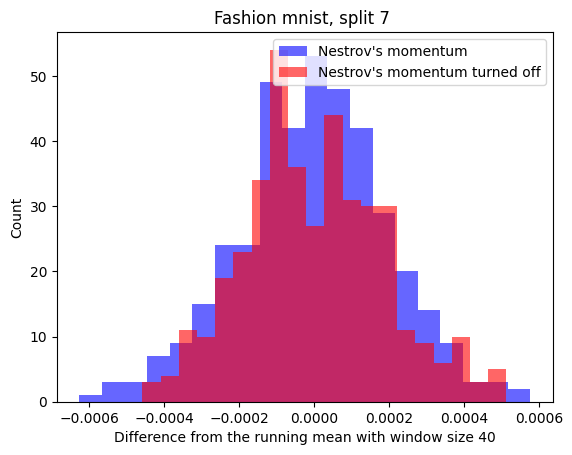

12
12


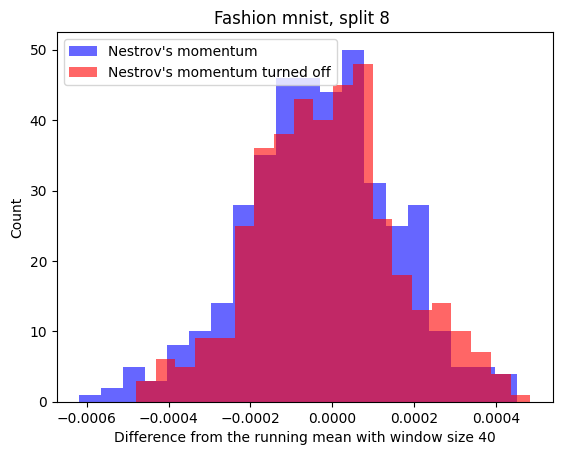

12
12


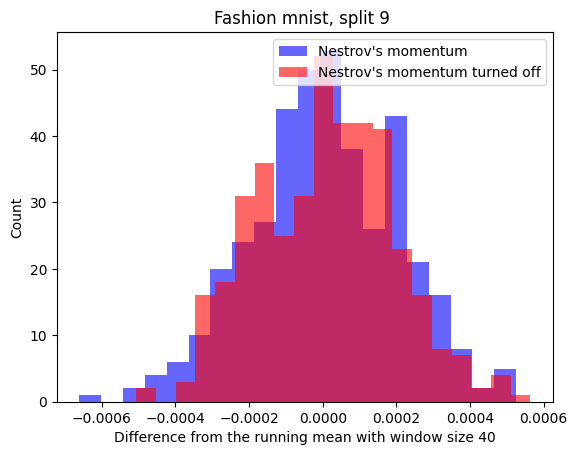

12
12


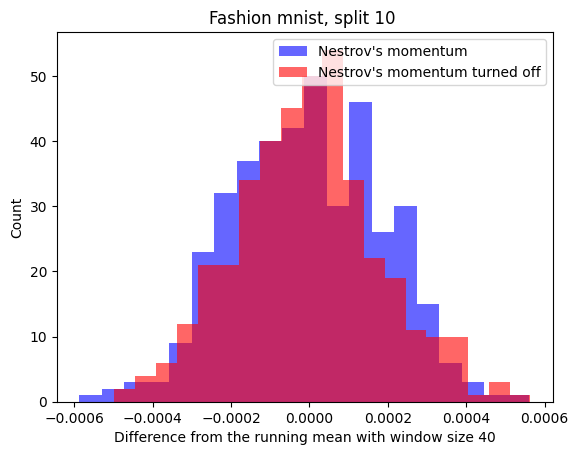

15
15


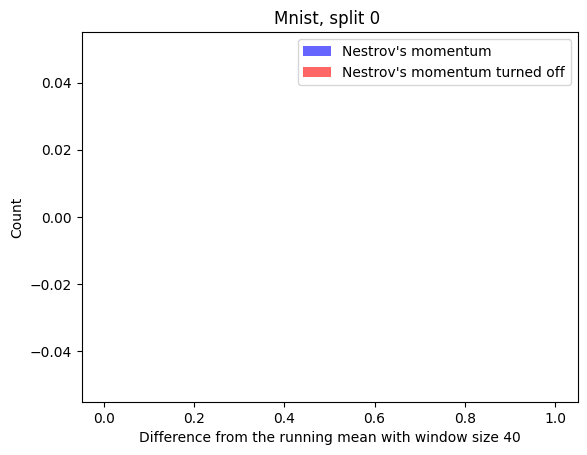

15
15


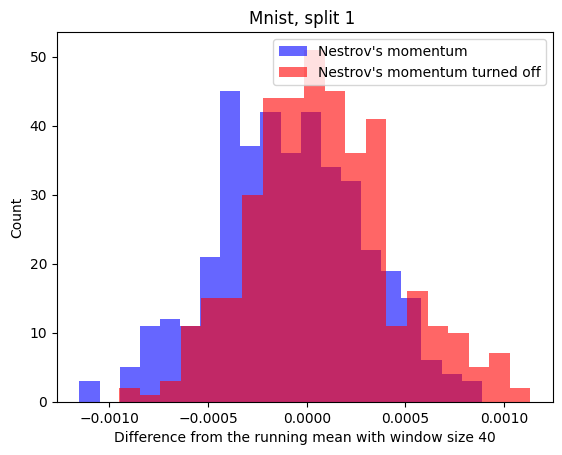

15
15


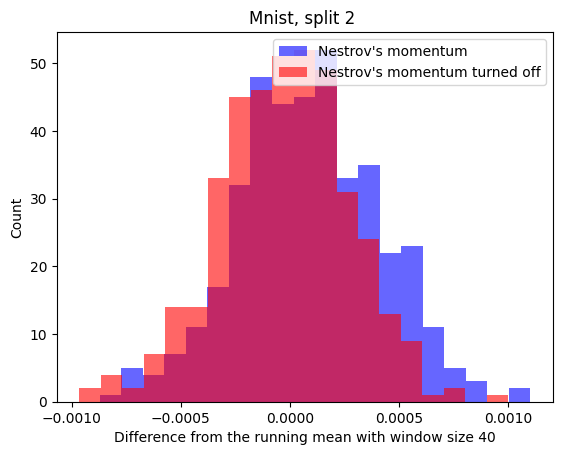

15
15


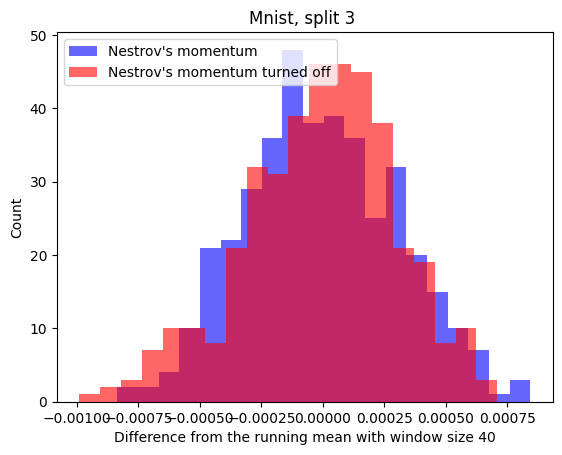

15
15


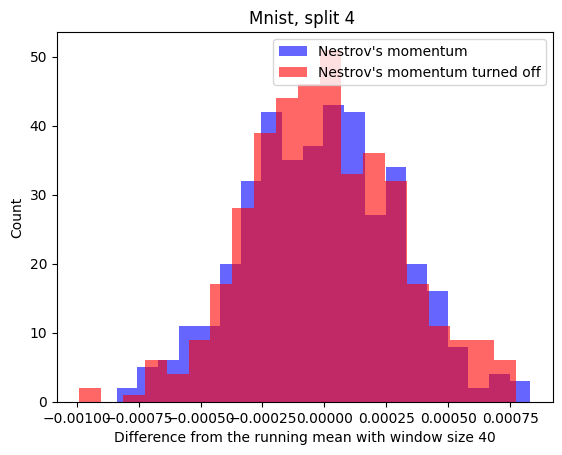

15
15


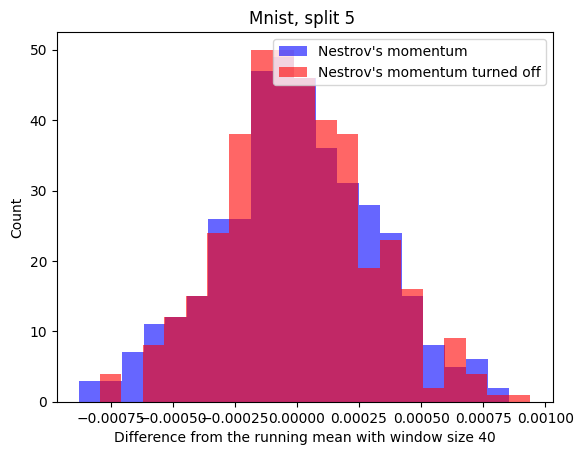

15
15


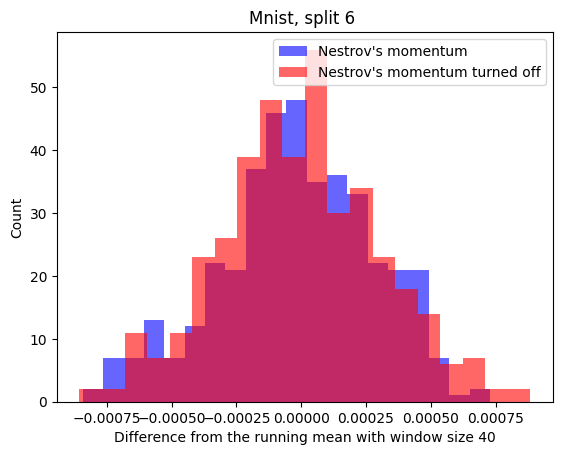

15
15


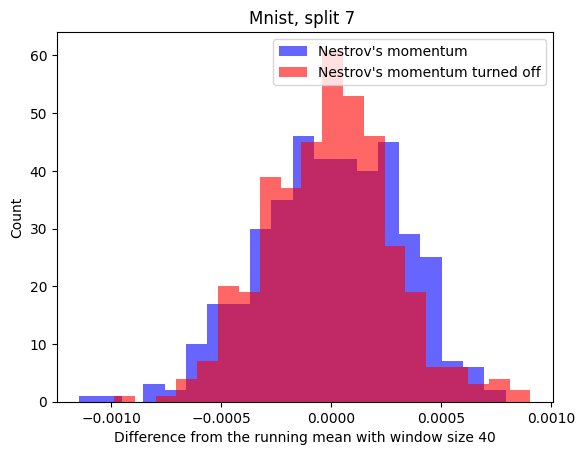

15
15


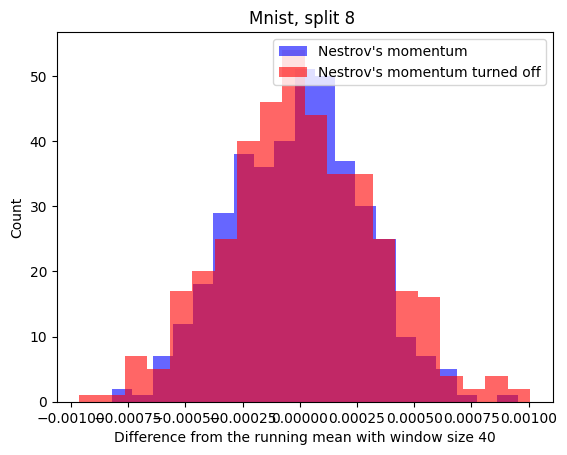

15
15


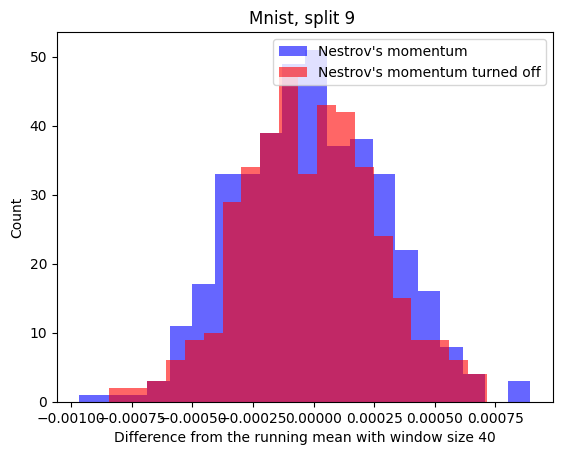

15
15


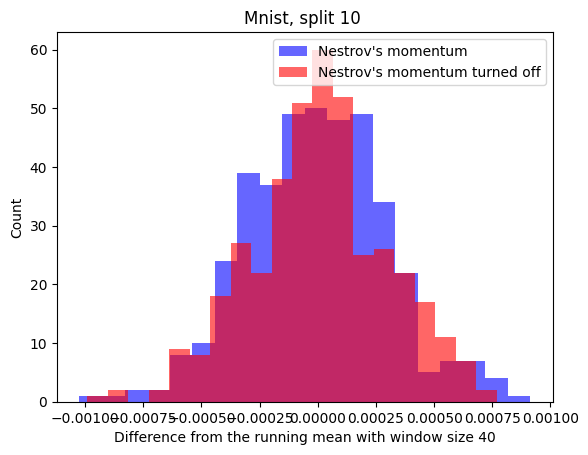

15
15


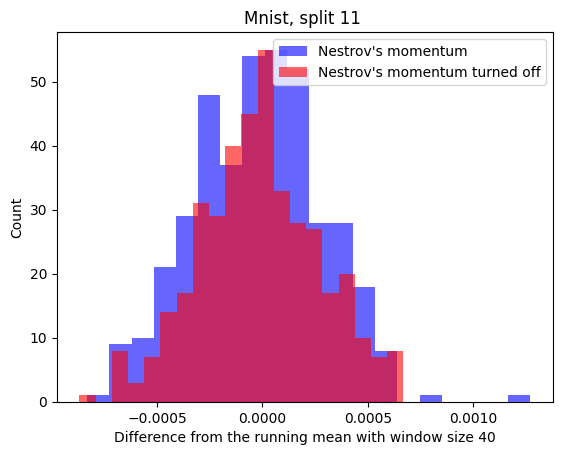

15
15


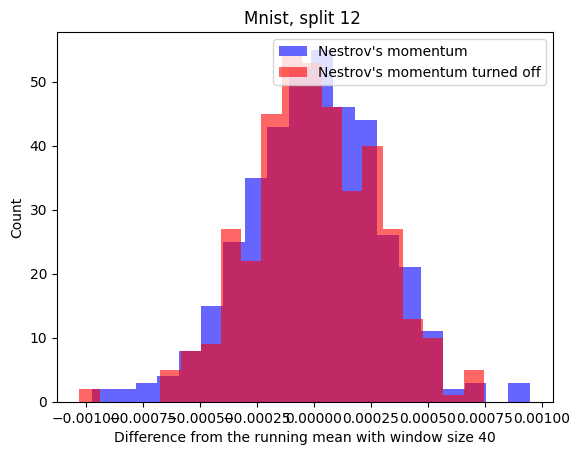

15
15


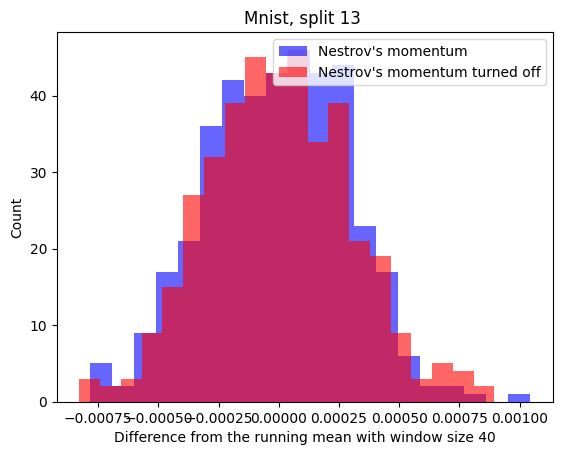

In [34]:
for i, dataset in enumerate(ans_values.values()):

    divisions = np.arange(0,iterations_range[i], 20)
    for j in range(len(divisions)):
        fig, ax = plt.subplots()
        for col, type, label in [('b', 'nesterov', "Nestrov's momentum"), ('r', 'no nesterov', "Nestrov's momentum turned off")]:

            diffs = dataset[type][0][:,:,0] - dataset[type][0][:,:,2]
            splits = np.split(diffs, divisions, axis=1)
            print(len(splits))
            ax.hist(splits[j].ravel(), bins=20, color=col, label=label, alpha=0.6)

            #
            # ax.plot(np.arange(iterations_range[i]), dataset[type][0][1,:,0],color=col, label=label)



        plt.ylabel("Count")
        plt.xlabel("Difference from the running mean with window size 40")
        if i == 0:
            plt.title(f"Mouse cortex scRNA, split {j}")
        else:
            plt.title(f"{dataset_names[i].capitalize()}, split {j} ")
        plt.legend()
        plt.show()
